In [27]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
import pandas as pd

This is based on the [homework of week 5](https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week05.pdf) of Statistical Rethinking book material.
I do the homework based on the questions but not following a specific order.
<br>
<br>
The dataset can be found [here](https://github.com/rmcelreath/rethinking/tree/Experimental/data)
<br>

In [28]:
df = pd.read_csv('../data/Wines2012.csv', sep=';')
df.head()

,judge,flight,wine,score,wine.amer,judge.amer
0,Jean-M Cardebat,white,A1,10.0,1,0
1,Jean-M Cardebat,white,B1,13.0,1,0
2,Jean-M Cardebat,white,C1,14.0,0,0
3,Jean-M Cardebat,white,D1,15.0,0,0
4,Jean-M Cardebat,white,E1,8.0,1,0


Standardizing score:

In [29]:
df['score_std'] = (df['score'] - df['score'].mean()) / df['score'].std()
df.score_std

0     -1.576604
1     -0.450458
2     -0.075076
3      0.300306
4     -2.327368
         ...   
175   -0.825840
176    0.300306
177    0.675687
178   -2.702750
179    1.051069
Name: score_std, Length: 180, dtype: float64

In [30]:
judge_cat = df['judge'].astype('category').cat.codes
wine_cat = df['wine'].astype('category').cat.codes

As the outcome **score** was standardized the priors we're chosen to be centered on 0 and having a standard deviation of 0.5.

In [48]:
SAMP_SIZE = 2000

with pm.Model() as m1:
    bJ = pm.Normal('bJ', 0, 1, shape=len(judge_cat.unique()))
    bW = pm.Normal('bW', 0, 1, shape=len(wine_cat.unique()))
    
    sigma = pm.Exponential('sigma', 1)
    mu = bJ[judge_cat] + bW[wine_cat]
    
    score_std = pm.Normal('score_std', mu=mu, sigma=sigma, observed=df['score_std'])
    
    m1_trace = pm.sample()
    
    # burned trace
    m1_trace = m1_trace[int(SAMP_SIZE/4):]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bW, bJ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [49]:
az.summary(m1_trace, credible_interval=.89, round_to=2)

/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(
/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bJ[0],-0.32,0.27,-0.80,0.20,0.01,0.01,588.29,588.29,593.25,908.49,1.00
bJ[1],0.21,0.26,-0.26,0.72,0.01,0.01,571.74,571.74,574.69,938.67,1.00
bJ[2],0.21,0.26,-0.28,0.70,0.01,0.01,548.01,548.01,548.26,795.96,1.00
bJ[3],-0.61,0.27,-1.10,-0.10,0.01,0.01,582.34,582.34,582.33,714.96,1.00
bJ[4],0.86,0.26,0.38,1.35,0.01,0.01,565.76,565.76,560.86,980.56,1.00
bJ[5],0.51,0.26,0.02,1.01,0.01,0.01,587.48,587.48,589.05,786.25,1.00
bJ[6],0.12,0.27,-0.37,0.67,0.01,0.01,584.26,584.26,586.36,922.17,1.00
bJ[7],-0.74,0.26,-1.20,-0.22,0.01,0.01,535.90,534.52,537.30,822.48,1.00
bJ[8],-0.40,0.26,-0.85,0.12,0.01,0.01,592.67,592.67,592.66,973.85,1.00
bW[0],0.16,0.31,-0.44,0.73,0.01,0.01,840.64,840.64,843.99,1088.23,1.00


/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (30), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'bJ\n0'}>,
        <AxesSubplot:title={'center':'bJ\n0'}>],
       [<AxesSubplot:title={'center':'bJ\n1'}>,
        <AxesSubplot:title={'center':'bJ\n1'}>],
       [<AxesSubplot:title={'center':'bJ\n2'}>,
        <AxesSubplot:title={'center':'bJ\n2'}>],
       [<AxesSubplot:title={'center':'bJ\n3'}>,
        <AxesSubplot:title={'center':'bJ\n3'}>],
       [<AxesSubplot:title={'center':'bJ\n4'}>,
        <AxesSubplot:title={'center':'bJ\n4'}>],
       [<AxesSubplot:title={'center':'bJ\n5'}>,
        <AxesSubplot:title={'center':'bJ\n5'}>],
       [<AxesSubplot:title={'center':'bJ\n6'}>,
        <AxesSubplot:title={'center':'bJ\n6'}>],
       [<AxesSubplot:title={'center':'bJ\n7'}>,
        <AxesSubplot:title={'center':'bJ\n7'}>],
       [<AxesSubplot:title={'center':'bJ\n8'}>,
        <AxesSubplot:title={'center':'bJ\n8'}>],
       [<AxesSubplot:title={'center':'bW\n0'}>,
        <AxesSubplot:title={'center':'bW\n0'}>],
       [<AxesSubplot:title={'c

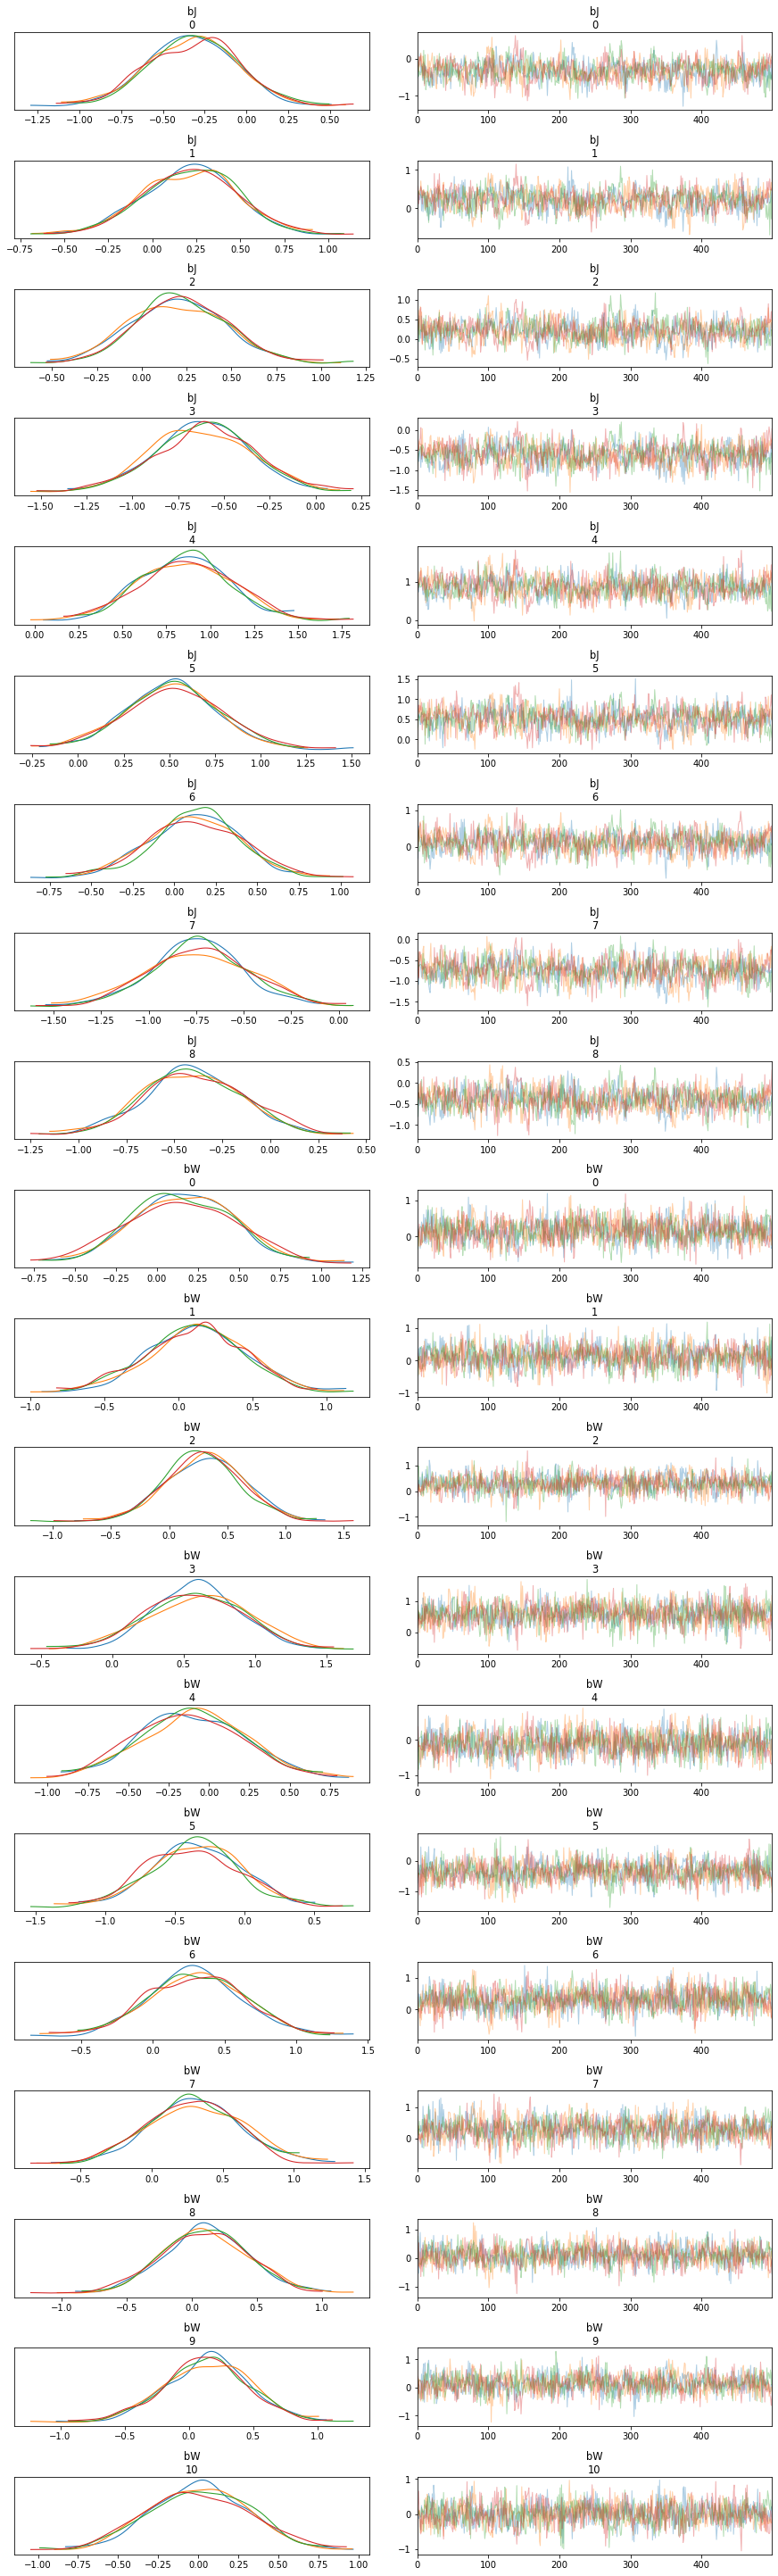

In [50]:
az.plot_trace(m1_trace)